# Train with video

In [1]:
from utils.common_utils import plotCircle, plotRectangle
import numpy as np

back_side = np.zeros((256, 256, 3))
image = plotCircle(back_side, vertex=(40, 40), size=40, color=(0.3, 0.5, 0.2))
image = plotRectangle(image, vertex=(200, 40), size=30, color=(0.7, 0.1, 0.1))
image = np.array([image])

In [2]:
from experiment.experiment import Experiment
from experiment.spatial_utils import preprocessTarget, PerceptualLoss, SpatialMapsGenerator, BatchGeneratorVideoAndImage
from models import spatial
from models.skip import skip
from utils.common_utils import generateSyntheticTexture
import torch
dtype = torch.cuda.FloatTensor
from IPython.core.display import display, HTML


config = {
    "PLOT": True,
    "optimizer": "adam",
    "lr": 1e-3,
    "num_iter": 1000,
    "show_every": 100,
    "maps_number": 4,
    "input_size": 128,
    "output_size": 128,
    "video_length": 129
}

skip_params = {'num_input_channels': config['maps_number'],
               'num_channels_down': [8, 16, 32, 64, 128],
               'num_channels_up': [8, 16, 32, 64, 128],
               'num_channels_skip': [4, 4, 4, 4, 4]}

config['net_params'] = [skip_params]

net = skip(**skip_params).type(dtype)


video = generateSyntheticTexture()[:128]
video = np.concatenate([video, image])

target = preprocessTarget(video, config["video_length"], config["output_size"])
loss = PerceptualLoss()
spatial_maps_generator_video = SpatialMapsGenerator(config["maps_number"])
spatial_maps_generator_image = SpatialMapsGenerator(config["maps_number"])
batch_generator = BatchGeneratorVideoAndImage(target, spatial_maps_generator_video, 
                                              spatial_maps_generator_image, 
                                              config["input_size"], config["input_size"])

parameters = list(net.parameters())
for var in spatial_maps_generator_video.spatial_variables.values():
    parameters.append(var)
    
for var in spatial_maps_generator_image.spatial_variables.values():
    parameters.append(var)

train_with_video = Experiment(config, parameters, batch_generator, net, loss)

Starting optimization with ADAM


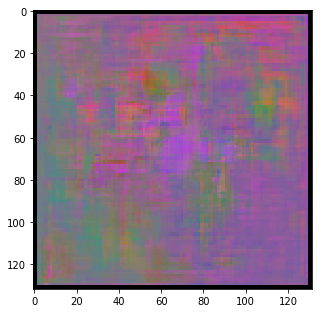

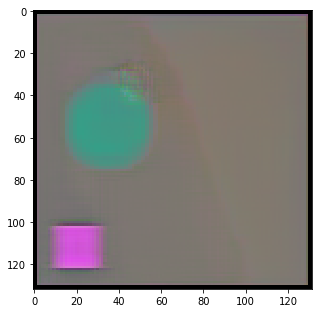

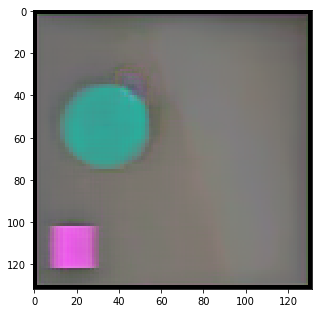

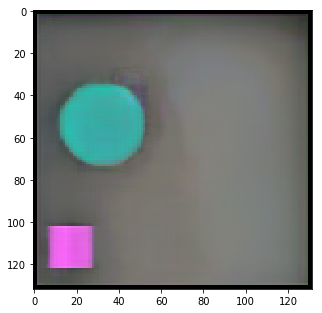

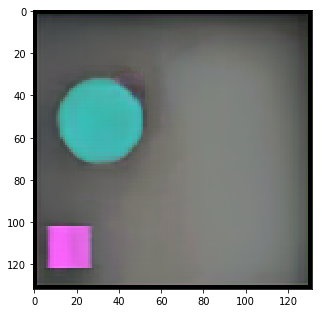

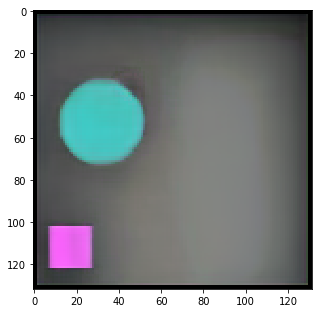

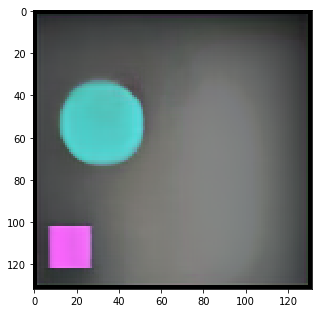

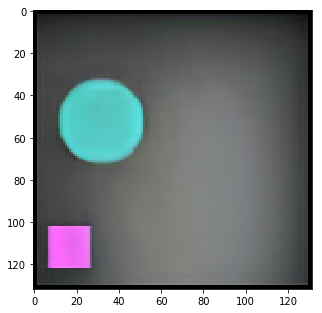

KeyboardInterrupt: 

In [5]:
train_with_video.run()

In [9]:
train_with_video.batch_generator_.maps_generator_image_.spatial_variables['gamma'] = train_with_video.batch_generator_.maps_generator_video_.spatial_variables['gamma']

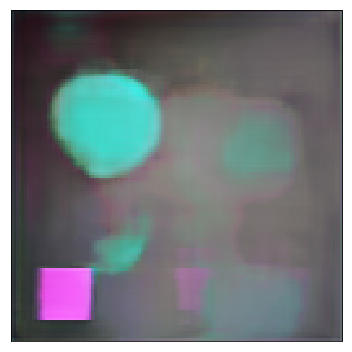

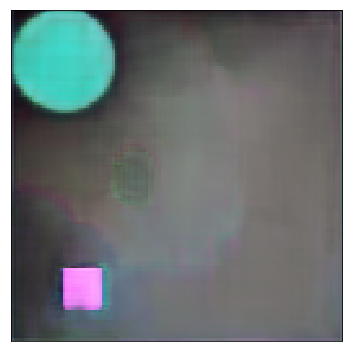

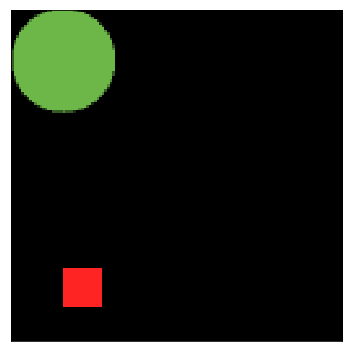

In [10]:
train_with_video.save_result();

In [11]:
from IPython.core.display import display, HTML
display(HTML(''' <video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video> '''.format(train_with_video.path_ +"/fit.mp4",
                    train_with_video.path_ +"/predict.mp4",
                    train_with_video.path_ +"/target.mp4")))

In [19]:
torch.save(net.state_dict(), train_with_video.path_ + '/net_state.dict')
for key in spatial_maps_generator.spatial_variables:
    torch.save(spatial_maps_generator.spatial_variables[key], train_with_video.path_ + '/{}.dict'.format(key))